### Notes:
- train only on the elements in the material?

### To-do:
- documentation: doc strings & code comments
- model tests

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics, linear_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pypredictbandgaps.material import Material
from pypredictbandgaps.bandgappredictions import BandGapPredictions

In [2]:
SiGe = Material(formula="SiGe",density=1.24,crystal_system="cubic",spacegroup="F43m") #taken from mp-1219182
Si2Ge4 = Material(formula="Si2Ge4")
Si5Ge2 = Material(formula="Si5Ge2")

materials_list = [SiGe,Si2Ge4,Si5Ge2]
band_gap_predictions = BandGapPredictions(materials_list)
band_gap_prediction_objects = band_gap_predictions.band_gap_prediction_objects

C:\Users\emily\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ridge regression alpha_choice = 0.20506122448979594
ridge regression alpha_choice = 0.20506122448979594
ridge regression alpha_choice = 0.20506122448979594


In [3]:
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    print(f""" 
    {material}
    -----------
    model score: {band_gap_prediction_object.model_score}
    band gap: {band_gap_prediction_object.predicted_band_gap} eV""")

 
    SiGe
    -----------
    model score: 0.41329799983058113
    band gap: 0.9750561026967026 eV
 
    Si2Ge4
    -----------
    model score: 0.36213468592656084
    band gap: 0.6741911780464406 eV
 
    Si5Ge2
    -----------
    model score: 0.3459979935498283
    band gap: 0.8124252017364584 eV


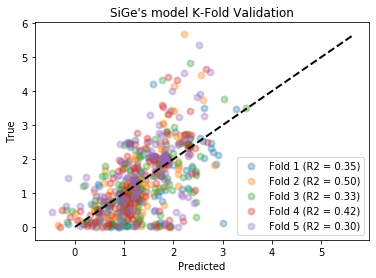

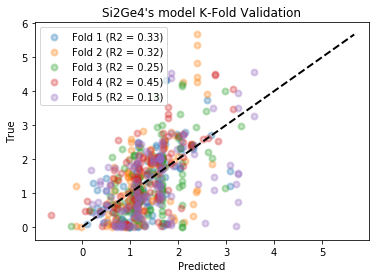

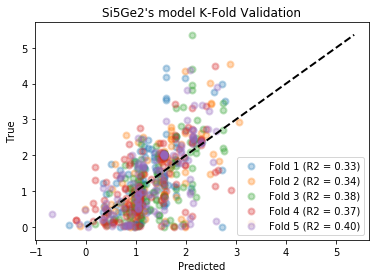

In [4]:
# K fold validation
# https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
for material, band_gap_prediction_object in band_gap_prediction_objects.items():
    scores = list()
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1

    X_train = band_gap_prediction_object.X_train
    y_train = band_gap_prediction_object.y_train
    model = band_gap_prediction_object.model
    
    for train, test in cv.split(X_train, y_train):
        prediction = model.fit(X_train[train],
                        y_train[train]).predict(X_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3, 
                    label='Fold %d (R2 = %0.2f)' % (i,score))
        i = i+1
    plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
                linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{material}'s model K-Fold Validation")
    plt.legend()
    plt.show()

In [5]:
feature_names = band_gap_prediction_objects["SiGe"].band_gap_dataframe_obj.dataframe.keys()[2:]
feature_names

Index(['spacegroup', 'density__gm_per_cc', 'crystal_system',
       'molecular_weight', 'H', 'He', 'Li', 'Be', 'B', 'C',
       ...
       'Mt', 'Uun', 'Uuu', 'Uub', 'Uut', 'Uuq', 'Uup', 'Uuh', 'Uus', 'Uuo'],
      dtype='object', length=122)

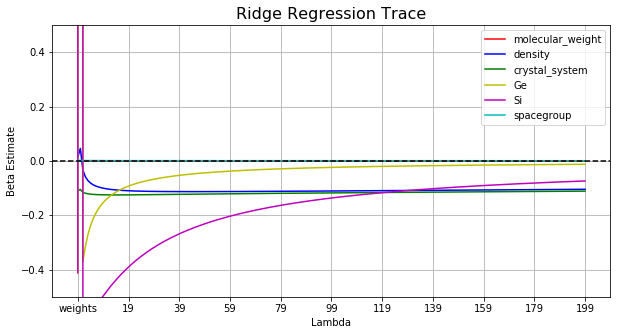

In [6]:
coef = band_gap_prediction_objects["SiGe"].model_weights 

ridge_df = pd.DataFrame({'variable': feature_names, 'weights': coef})
ridge_train_pred = []
ridge_test_pred = []

X_train = band_gap_prediction_objects["SiGe"].X_train
y_train = band_gap_prediction_objects["SiGe"].y_train
X_test = band_gap_prediction_objects["SiGe"].X_test
y_test = band_gap_prediction_objects["SiGe"].y_test

alphas = np.arange(0, 200, 1)

for alpha in alphas:
    ridge_reg = linear_model.Ridge(alpha=alpha)
    ridge_reg.fit(X_train, y_train)
    var_name = str(alpha)
    ridge_df[var_name] = ridge_reg.coef_
    
    # prediction
    ridge_train_pred.append(ridge_reg.predict(X_train))
    ridge_test_pred.append(ridge_reg.predict(X_test))
    
#ridge_df = ridge_df.set_index('variable').T.rename_axis('estimate').rename_axis(None, 1).reset_index()
ridge_df = ridge_df.set_index('variable').T#.rename_axis('estimate').rename_axis(None, 1).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(ridge_df.RM, 'r', ridge_df.ZN, 'g', ridge_df.RAD, 'b', ridge_df.CRIM, 'c', ridge_df.TAX, 'y')
ax.plot(
    ridge_df.molecular_weight, "r",
    ridge_df.density__gm_per_cc, "b",
    ridge_df.crystal_system, "g",
    ridge_df.Ge, "y",
    ridge_df.Si, "m",
    ridge_df.spacegroup, "c",
)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel("Lambda")
ax.set_ylabel("Beta Estimate")
ax.set_title("Ridge Regression Trace", fontsize=16)
#ax.legend(labels=['Room','Residential Zone','Highway Access','Crime Rate','Tax'])
ax.legend(labels=["molecular_weight","density","crystal_system","Ge","Si","spacegroup"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.set_ylim(-0.5,0.5)
#ax.set_ylim(-0.001,0.005)
ax.grid(True)

In [7]:
# features that are the least efficient in your estimation will "shrink" the fastest
# the faster a coefficient is shrinking the less important it is in prediction